In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.font_manager as fm

mpl.rcParams['axes.unicode_minus'] = False # 그래프에서 마이너스(-) 폰트 깨짐 방지
mpl.rc('font', family='NanumBarunGothic')

# 1. 구조 살펴보기

In [2]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


* null값이 있고, numerical features와 categorical features가 혼합되어 있다.
* data type을 봤을 때 특정 feature의 경우 numerical analysis가 좋을지 categorical analysis가 좋을지 생각해 볼 필요가 있다.

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* PassengerId는 전부 고유한 ID를 가짐으로 Survived에 영향이 없을 것이라 판단하여 제외 예정
* Age와 Fare의 경우 구간으로 나누면 모든 features가 scale이 비슷해 정규화 필요성이 없어보인다.

In [6]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Phillips, Miss. Kate Florence (""Mrs Kate Louis...",male,1601,B96 B98,S
freq,1,577,7,4,644


* Ticket도 Survived에 영향이 없을 것이라 판단하여 제외 예정
* Cabin에 null값이 많이 측정된다. unique 수도 많고 대체할 feature(Pclass 등)가 있기 때문에 Cabin도 제외 예정

In [7]:
train.shape, test.shape

((891, 12), (418, 11))

# 2. EDA

In [8]:
num_features = train.describe().columns.values[1:-1]

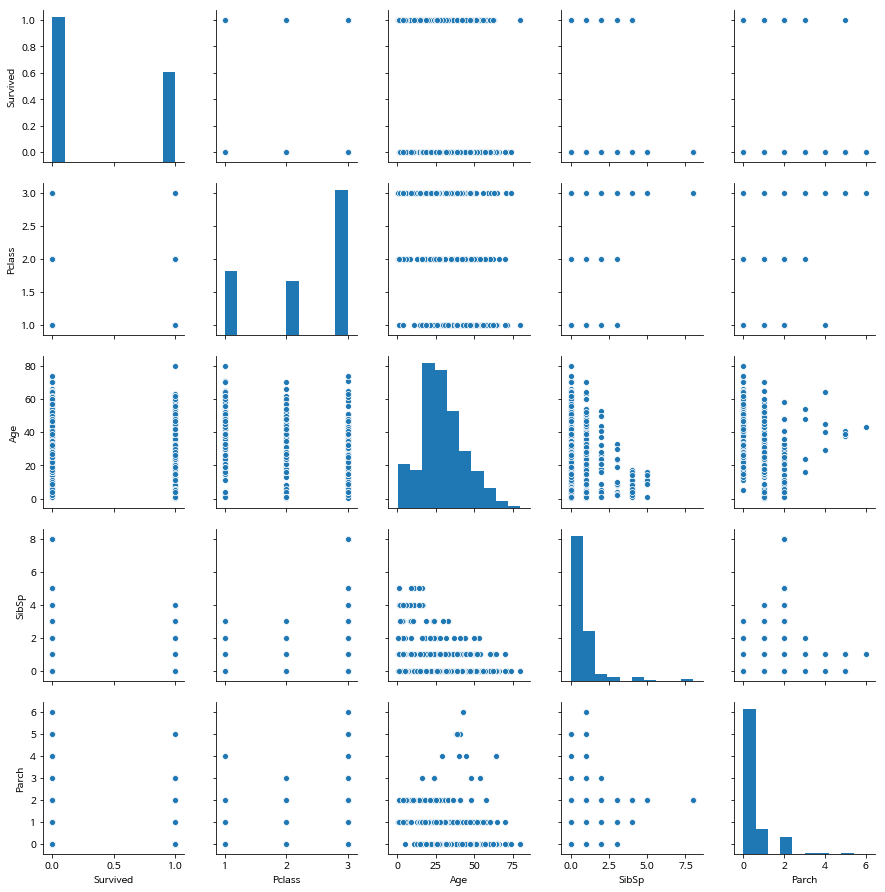

In [9]:
sns.pairplot(train[num_features])

각 히스토그램을 보면 생존자 수에 비해 사망자 수가 더 많고, 승선한 고객은 3등급이 제일 많으며, 연령층은 정규분포 형태와 비슷한 분포를 보이고, 동반 탑승객은 대체적으로 많지 않다.

## 2.1. 일변량 탐색

#### 생존율

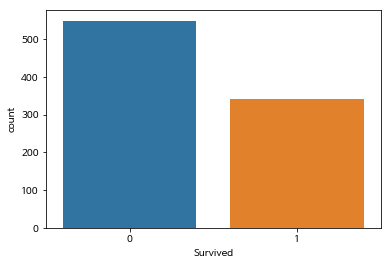

In [10]:
sns.countplot('Survived', data=train)

In [11]:
train['Survived'].mean()

0.3838383838383838

생존자가 38% 비율로 많지 않다.

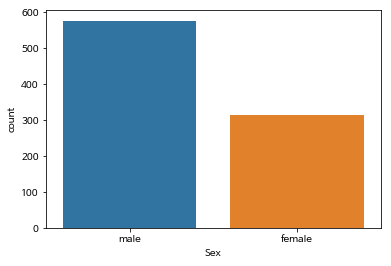

In [12]:
sns.countplot(train['Sex'])

In [13]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

여성 탑승객이 1.5배 이상 많다.

## 2.2. 이변량 탐색

#### Pclass에 따른 생존율

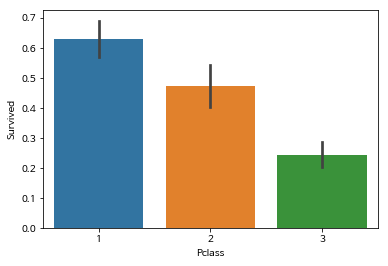

In [14]:
sns.barplot('Pclass', 'Survived', data=train)

In [17]:
train[['Pclass', 'Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


확실히 좋은 등급일수록 생존율이 높다. 구출 우선 순위와 등급별 승객 수 차이의 영향으로 보인다.

#### Sex에 따른 생존율

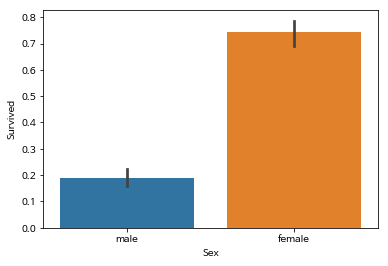

In [16]:
sns.barplot('Sex', 'Survived', data=train)

In [15]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


성별에 따라 매우 큰 차이를 보이고 있다.

#### Age에 따른 생존율

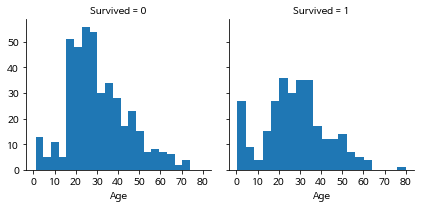

In [18]:
grid = sns.FacetGrid(train, col='Survived')
grid.map(plt.hist, 'Age', bins=20)
plt.xticks(range(0, 90, 10))
plt.show()

* 어린 아이들은 생존율이 더 높은 것을 볼 수 있다. 그 외 대체적으로 생존율이 더 낮다.

#### SibSp에 따른 생존율

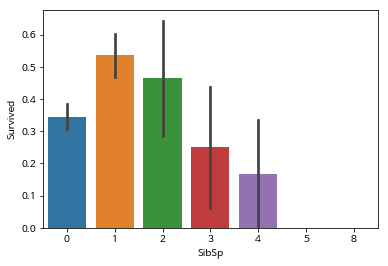

In [19]:
sns.barplot('SibSp', 'Survived', data=train)

In [20]:
train[['SibSp', 'Survived']].groupby('SibSp').mean().sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


* 소규모 탑승일수록 생존율이 높다.
* 동승객이 없는 경우의 생존율이 낮은 것은 또 다른 영향이 있어보인다. 홀로 탑승한 고객의 경우 남자가 많을 것이라는 생각이 든다. 추가로 살펴볼 필요가 있다.

#### Parch에 따른 생존율

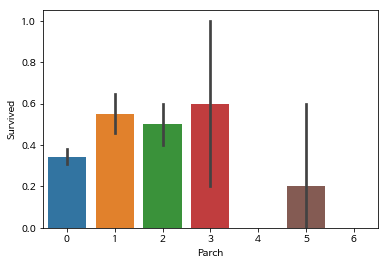

In [21]:
sns.barplot('Parch', 'Survived', data=train)

In [22]:
train[['Parch', 'Survived']].groupby('Parch').mean().sort_values(by='Survived', ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


* 위와 마찬가지로 소규모 탑승일수록 생존율이 더 높으며, 홀로 탑승한 고객의 생존율을 따로 살펴볼 필요가 있다.

#### Fare에 따른 생존율

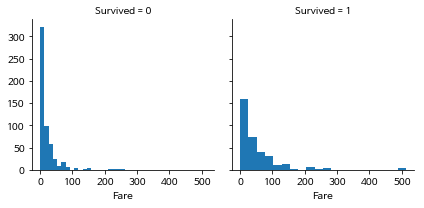

In [23]:
grid = sns.FacetGrid(train, col='Survived')
grid.map(plt.hist, 'Fare', bins=20)

* 저렴한 비용을 지불한 승객일수록 생존율이 낮다. Fare에 따라 PClass나 Cabin의 위치가 달라지고, 구출 우선 순위 등과도 연관성이 있을 것이다.

#### Embarked에 따른 생존율

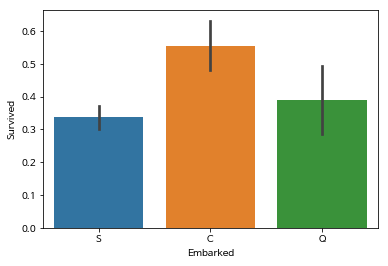

In [24]:
sns.barplot('Embarked', 'Survived', data=train)

In [25]:
train[['Embarked', 'Survived']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


* C(Cherbourg)에서 탑승한 사람들의 생존율이 높다. Cherbourg에서 탑승한 사람들의 또 다른 특징이 있는지 살펴볼 필요가 있다.

## 2.3. 다변량 탐색

#### Pclass와 Survived에 따른 나이 분포

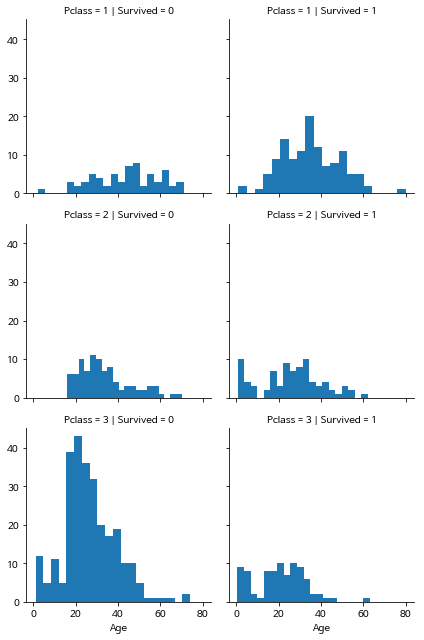

In [26]:
grid = sns.FacetGrid(train, row='Pclass', col='Survived')
grid.map(plt.hist, 'Age', bins=20)

* 확실히 1등급과 3등급의 생존율 차이가 보인다.
* 3등급일수록 평균 연령이 더 낮아보인다. 보통 젊을수록 경제력이 낮기 때문에 젊은 사람들이 저렴한 3등급을 이용했을 것이다.

#### 홀로 탑승한 고객의 생존율
일변량 탐색에서 동반탑승객이 소규모일수록 생존율이 높았는데 홀로 탑승한 경우 다른 경향을 보여 홀로 탑승한 고객의 특징이 있을거라는 추측을 하였다. 따라서 홀로 탑승한 고객에 대해 탐색한다.

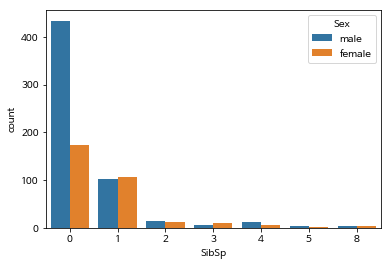

In [27]:
sns.countplot('SibSp', hue='Sex', data=train)

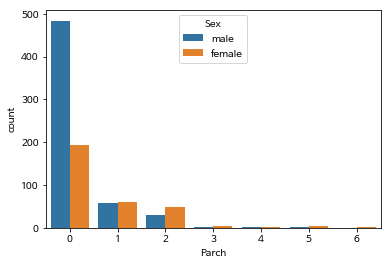

In [28]:
sns.countplot('Parch', hue='Sex', data=train)

In [29]:
train[['Sex', 'Parch', 'SibSp', 'Survived']].groupby(['Sex', 'Parch', 'SibSp']).mean().reset_index().sort_values('Survived', ascending=False).reset_index()

,index,Sex,Parch,SibSp,Survived
0,15,female,3,0,1.000000
1,3,female,0,3,1.000000
2,17,female,3,2,1.000000
3,6,female,1,2,1.000000
4,4,female,1,0,0.875000
5,8,female,2,0,0.800000
6,1,female,0,1,0.793651
7,0,female,0,0,0.785714
8,5,female,1,1,0.769231
9,9,female,2,1,0.727273


홀로 탑승한 승객은 대다수 남성 승객이며, 동반 탑승객 수에 따른 생존율에서도 15% 생존율로 24위에 위치한 걸 볼 수 있다(홀로 탑승한 여성 승객의 경우 8위로 78%의 생존율을 보인다).   
따라서 홀로 탑승한 승객의 생존율이 낮은 것은 남성 승객의 생존율이 커다란 영향을 미친 것으로 보인다.  
홀로 탑승한 남성의 경우 구출 활동에 협조하다가 미쳐 생존하지 못했거나 가족이 없어 구출 우선 순위에서 우위를 점하지 못했을 것으로 보인다.

#### Embarked에 따른 생존율 특징 파악
일변량 탐색에서 C > Q > S로 생존율이 높았다. C(Cherbourg)에서 탑승한 고객들이 구출 특혜를 받을만한 요소가 있어서 생존율에 영향을 주었는지 살펴본다.

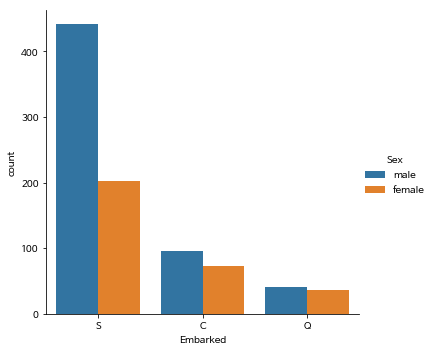

In [30]:
sns.catplot('Embarked', kind='count', hue='Sex', data=train)

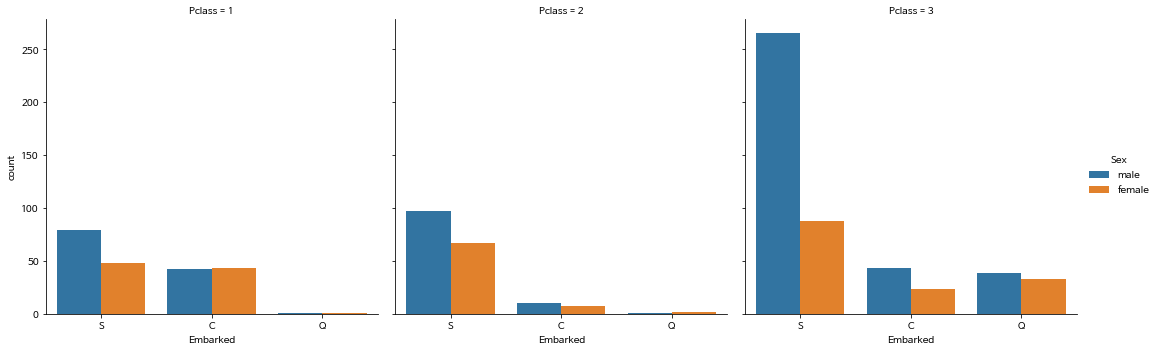

In [31]:
sns.catplot('Embarked', col='Pclass', hue='Sex', kind='count', data=train)

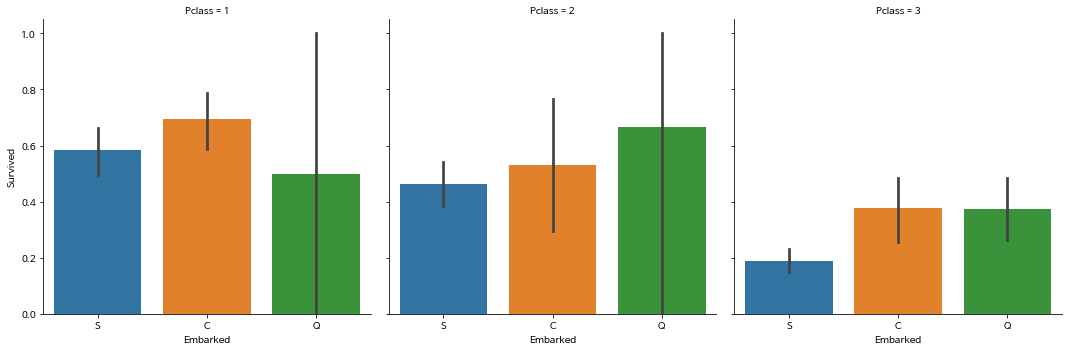

In [32]:
sns.catplot('Embarked', 'Survived', col='Pclass', kind='bar', data=train)

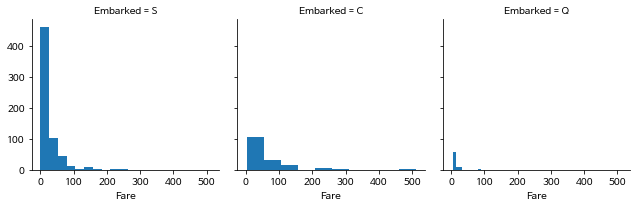

In [33]:
grid = sns.FacetGrid(train, col='Embarked')
grid.map(plt.hist, 'Fare')

일변량 탐색에서 C(Cherbourg)에서 탑승한 승객이 생존율이 가장 높았던 것은 1등급에서 우연하게 C에서 탑승한 승객들의 생존율이 높았기 때문인 것으로 보인다.  
그 다음으로 생존율이 높은 Q(Queenstown)에서 탑승한 승객의 생존율은 다른 Embarked에서 탑승한 승객들에 비해 수가 적기 때문으로 보인다.  
S(Southampton)의 경우 승객 수가 매우 많기 때문에 생존율이 떨어지는 것으로 보인다.  
Fare를 살펴보아도 C에서 탑승한 승객들의 요금 분포가 큰 특징을 보이고 있지 않다.  
즉, Pclass나 Fare를 보면 C에서 탑승한 승객들이 구출 특혜를 받을만한 요소는 보이지 않는다.  
따라서 Embarked는 생존율에 많은 영향을 끼치지 않는 것으로 보인다.

# 3. Pre-Processing
#### Missing Values

In [34]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_train.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [35]:
print(set(X_train.columns) - set(test.columns))
print(set(test.columns) - set(X_train.columns))

set()
set()


In [36]:
df = pd.concat([X_train, test], sort=True)
missing = df.isnull().sum()
missing = missing[missing > 0]
missing

Age          263
Cabin       1014
Embarked       2
Fare           1
dtype: int64

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

class Imputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Age
        self.low = X['Age'].mean() - X['Age'].std()
        self.high = X['Age'].mean() + X['Age'].std()
        # Embarked
        self.embarked = X['Embarked'].mode()[0]
        # Fare
        self.fare_median = X['Fare'].median()
        return self
    
    def transform(self, X):
        # Age
        size = X['Age'].isnull().sum()
        rnd_age = np.random.randint(self.low, self.high, size)
        X.loc[np.isnan(X['Age']), 'Age'] = rnd_age
        X['Age'] = X['Age'].astype(int)
        # Embarked
        X['Embarked'].fillna(self.embarked, inplace=True)
        # Fare
        X['Fare'].fillna(self.fare_median, inplace=True)
        return X

#### Feature Engineering

In [38]:
import re

def get_title(name):
    pattern = re.compile('[A-Za-z]+\.')
    search = pattern.search(name)
    if search:
        return pattern.sub(search.group()[:-1], search.group())
    return ""

In [39]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        _, self.fare_bins = pd.qcut(X['Fare'], 4, retbins=True)
        return self
    
    def transform(self, X, add_title=True):
        X = X.copy()
        ## add features
        X['Age'] = pd.cut(X['Age'], bins=[0, 20, 30, 40, 60, 80], labels=False, include_lowest=True)
        X['HasCabin'] = X['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
        X['Accompanier'] = X['SibSp'] + X['Parch']
        X['IsAlone'] = 0
        X.loc[X['Accompanier']==0, 'IsAlone'] = 1
        X['Fare'] = pd.cut(X['Fare'], bins=self.fare_bins, labels=False, include_lowest=True)
        if add_title:
            X['Title'] = X['Name'].apply(get_title)
            X['Title'].replace(['Mlle', 'Ms'], 'Miss', inplace=True)
            X['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare', inplace=True)
            X['Title'].replace('Mme', 'Mrs', inplace=True)
            X.replace({'Title': {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}},
                     inplace=True)
        
        ## mapping
        X.replace({'Sex': {'female': 0, 'male': 1},
                  'Embarked': {'S': 0, 'C': 1, 'Q': 2}}, inplace=True)
        
        ## casting
        X['Sex'].astype(int)
        X['Embarked'].astype(int)
        X['Age'].astype(int)
        X['Fare'].astype(int)
        
        ## drop
        X.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
        return X

In [40]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(Imputer(), FeatureEngineering())
pipe.fit(X_train, y_train)
X_train_transformed = pipe.transform(X_train)
X_test_transformed = pipe.transform(test)

#### correlation

In [41]:
train_transformed = pd.concat([X_train_transformed, y_train], axis=1)

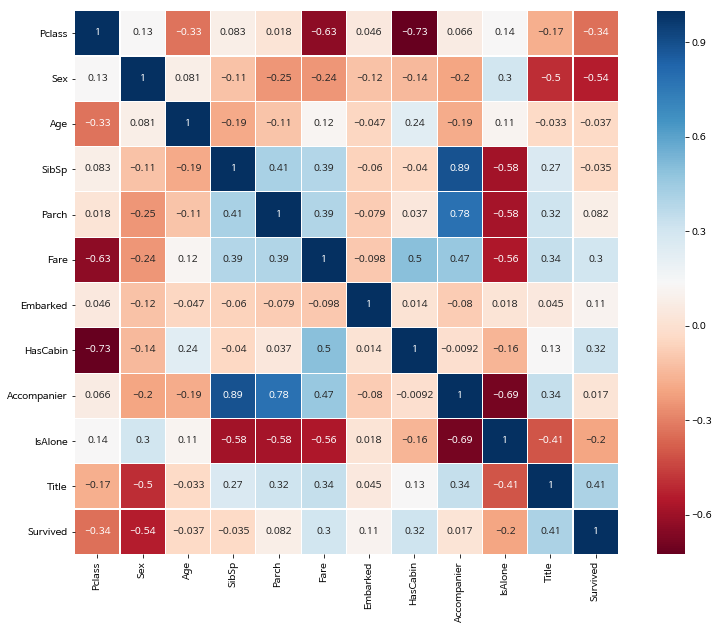

In [42]:
plt.figure(figsize=(14, 10))
cmap = plt.cm.RdBu
sns.heatmap(train_transformed.corr(), cmap=cmap, linewidths=0.1, linecolor='white',
           annot=True, square=True, vmax=1.0)

Survived와의 상관계수는 Sex > Title > Pclass > ... 순으로 나타난다.  
Sex와 IsAlone의 경우 인코딩된 수치의 할당 때문에 음의 상관계수를 보이고 있다.  
즉 Sex의 경우 0으로 할당된 여성 고객일수록 생존율이 높으며, IsAlone의 경우 0으로 할당된 '혼자 탑승하지 않았다'일수록 생존율이 높아진다는 걸 의미한다.

# 4. Modeling

## 4.1. Simple Modeling
### 4.1.1. Default Models

In [43]:
from sklearn.model_selection import cross_val_score

def get_scores(clfs, X, y, plot=False):
    scores = []
    idxs = []
    all_scores = []
    cv = 10
    for clf in clfs:
        clf_scores = cross_val_score(clf, X, y, cv=cv)
        scores.append(round(clf_scores.mean() * 100, 2))
        idxs.append(clf.__class__.__name__)
        if plot:
            all_scores.append(clf_scores)
    
    if plot:
        for i in range(len(clfs)):
            plt.plot([i]*cv, all_scores[i], '.')
        plt.boxplot([all_scores[i] for i in range(len(clfs))], labels=[idxs[i] for i in range(len(clfs))])
        plt.xticks(rotation=90)
    compare_df = pd.DataFrame({'Score': scores}, index=idxs).sort_values('Score', ascending=False)
    return compare_df

,Score
SVC,82.72
XGBClassifier,82.72
GradientBoostingClassifier,81.94
AdaBoostClassifier,81.60
ExtraTreesClassifier,81.50
RandomForestClassifier,81.26
KNeighborsClassifier,80.71
LinearSVC,80.69
DecisionTreeClassifier,80.49
LogisticRegression,80.36


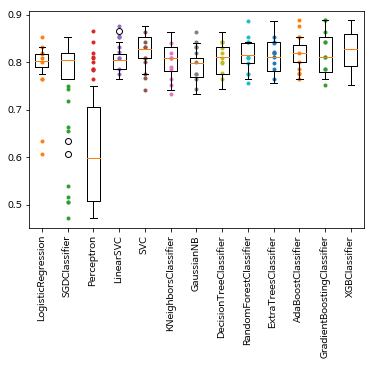

In [44]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

clfs = [LogisticRegression(), SGDClassifier(), Perceptron(), LinearSVC(), SVC(),
        KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(), 
        RandomForestClassifier(), ExtraTreesClassifier(), AdaBoostClassifier(), 
        GradientBoostingClassifier(), xgb.XGBClassifier()]
get_scores(clfs, X_train_transformed, y_train, plot=True)

SVC와 ensemble 모델들이 좋은 성능을 보인다. SVC와 ensemble 모델을 사용하여 하이퍼파라미터 튜닝과 stacking model을 만들어 본다.

### 4.1.2. Tunned Models

#### SVC

In [45]:
from sklearn.model_selection import GridSearchCV

params_grid = {'C': [0.2, 0.3, 0.5],
              'kernel': ['rbf', 'linear'],
              'random_state': [42]
              }

svc_grid = GridSearchCV(SVC(), params_grid, cv=10, n_jobs=-1,
                            scoring='accuracy')
svc_grid.fit(X_train_transformed, y_train)
svc_best_params = svc_grid.best_params_
print('best params : ', svc_best_params)

best params :  {'C': 0.5, 'kernel': 'rbf', 'random_state': 42}


In [46]:
svc_cv = pd.DataFrame(svc_grid.cv_results_)
svc_cv_score = svc_cv['mean_test_score'][svc_grid.best_index_]
svc_cv_std = svc_cv['std_test_score'][svc_grid.best_index_]
svc_cv_score, svc_cv_std

(0.8271604938271605, 0.029838847433096664)

#### GradientBoostingClassifier

In [47]:
params_grid = {'learning_rate': [0.05, 0.1, 0.5],
              'n_estimators': [30, 50, 100],
              'max_depth' : [2, 3, 4],
              'min_samples_leaf': [1, 2],
              'random_state': [42]
              }

gradboost_grid = GridSearchCV(GradientBoostingClassifier(), params_grid, cv=10, n_jobs=-1,
                            scoring='accuracy')
gradboost_grid.fit(X_train_transformed, y_train)
gradboost_best_params = gradboost_grid.best_params_
print('best params : ', gradboost_best_params)

best params :  {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 50, 'random_state': 42}


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [48]:
gradboost_cv = pd.DataFrame(gradboost_grid.cv_results_)
gradboost_cv_score = gradboost_cv['mean_test_score'][gradboost_grid.best_index_]
gradboost_cv_std = gradboost_cv['std_test_score'][gradboost_grid.best_index_]
gradboost_cv_score, gradboost_cv_std

(0.8361391694725028, 0.029840626084606973)

#### XGBClassifier

In [49]:
params_grid = {'learning_rate': [0.005, 0.01, 0.1],
               'max_depth': [10, 15, 20],
               'n_estimators': [100, 300, 500],
               'random_state': [42]
              }

xgboost_grid = GridSearchCV(xgb.XGBClassifier(), params_grid, cv=5, n_jobs=-1,
                            scoring='accuracy')
xgboost_grid.fit(X_train_transformed, y_train)
xgboost_best_params = xgboost_grid.best_params_
print('best params : ', xgboost_best_params)

best params :  {'learning_rate': 0.005, 'max_depth': 10, 'n_estimators': 500, 'random_state': 42}


In [50]:
xgboost_cv = pd.DataFrame(xgboost_grid.cv_results_)
xgboost_cv_score = xgboost_cv['mean_test_score'][xgboost_grid.best_index_]
xgboost_cv_std = xgboost_cv['std_test_score'][xgboost_grid.best_index_]
xgboost_cv_score, xgboost_cv_std

(0.8294051627384961, 0.017735750615938482)

#### ExtraTreesClassifier

In [51]:
params_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [2, 5, 7],
              'min_samples_leaf': [1, 2],
              'n_jobs': [-1],
              'random_state': [42]}
extra_grid = GridSearchCV(ExtraTreesClassifier(), params_grid, cv=10,
                            scoring='accuracy', n_jobs=-1)
extra_grid.fit(X_train_transformed, y_train)
extra_best_params = extra_grid.best_params_
print('best params :', extra_best_params)

best params : {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}


In [52]:
extra_cv = pd.DataFrame(extra_grid.cv_results_)
extra_cv_score = extra_cv['mean_test_score'][extra_grid.best_index_]
extra_cv_std = extra_cv['std_test_score'][extra_grid.best_index_]
extra_cv_score, extra_cv_std

(0.8271604938271605, 0.03129746822887534)

#### AdaBoostClassifier

In [53]:
params_grid = {'n_estimators': [100, 500, 1000],
              'learning_rate': [0.01, 0.05, 0.1],
              'random_state': [42]}
adaboost_grid = GridSearchCV(AdaBoostClassifier(), params_grid, cv=10,
                            scoring='accuracy', n_jobs=-1)
adaboost_grid.fit(X_train_transformed, y_train)
adaboost_best_params = adaboost_grid.best_params_
print('best params :', adaboost_best_params)

best params : {'learning_rate': 0.05, 'n_estimators': 500, 'random_state': 42}


In [54]:
adaboost_cv = pd.DataFrame(adaboost_grid.cv_results_)
adaboost_cv_score = adaboost_cv['mean_test_score'][adaboost_grid.best_index_]
adaboost_cv_std = adaboost_cv['std_test_score'][adaboost_grid.best_index_]
adaboost_cv_score, adaboost_cv_std

(0.8260381593714927, 0.029735646400970036)

#### RandomForestClassifier

In [55]:
params_grid = {'n_estimators': [100, 500, 700],
              'max_depth': [2, 5, 7],
              'min_samples_leaf': [1, 2],
              'n_jobs': [-1],
              'random_state': [42]}
rnd_grid = GridSearchCV(RandomForestClassifier(), params_grid, cv=10,
                            scoring='accuracy', n_jobs=-1)
rnd_grid.fit(X_train_transformed, y_train)
rnd_best_params = rnd_grid.best_params_
print('best params :', rnd_best_params)

best params : {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}


In [56]:
rnd_cv = pd.DataFrame(rnd_grid.cv_results_)
rnd_cv_score = rnd_cv['mean_test_score'][rnd_grid.best_index_]
rnd_cv_std = rnd_cv['std_test_score'][rnd_grid.best_index_]
rnd_cv_score, rnd_cv_std

(0.8327721661054994, 0.029549382191519948)

#### compare tuned models

,Score
GradientBoostingClassifier,83.61
RandomForestClassifier,83.28
ExtraTreesClassifier,82.72
SVC,82.71
AdaBoostClassifier,82.61
XGBClassifier,82.06


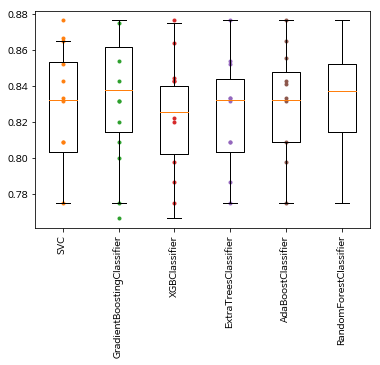

In [57]:
svc_clf = SVC(**svc_best_params)
gradboost_clf = GradientBoostingClassifier(**gradboost_best_params)
xgboost_clf = xgb.XGBClassifier(**xgboost_best_params)
extra_clf = ExtraTreesClassifier(**extra_best_params)
adaboost_clf = AdaBoostClassifier(**adaboost_best_params)
rnd_clf = RandomForestClassifier(**rnd_best_params)

clfs = [svc_clf, gradboost_clf, xgboost_clf, extra_clf, adaboost_clf, rnd_clf]
get_scores(clfs, X_train_transformed, y_train, plot=True)

### 4.1.3. Feature Importances

In [58]:
rnd_importances = rnd_clf.fit(X_train_transformed, y_train).feature_importances_
extra_importances = extra_clf.fit(X_train_transformed, y_train).feature_importances_
adaboost_importances =  adaboost_clf.fit(X_train_transformed, y_train).feature_importances_
gradboost_importances =  gradboost_clf.fit(X_train_transformed, y_train).feature_importances_

In [59]:
importances = pd.DataFrame({'rnd_importances': rnd_importances,
             'extra_importances': extra_importances,
             'adaboost_importances': adaboost_importances,
             'gradboost_importances': gradboost_importances}, 
             index=X_train_transformed.columns.values)
importances

,rnd_importances,extra_importances,adaboost_importances,gradboost_importances
Pclass,0.105817,0.109037,0.090,0.148806
Sex,0.258172,0.456562,0.032,0.195490
Age,0.026288,0.014297,0.068,0.008982
SibSp,0.033568,0.023258,0.052,0.000000
Parch,0.017427,0.014052,0.022,0.002106
Fare,0.058648,0.038205,0.090,0.012877
Embarked,0.018635,0.017117,0.042,0.007907
HasCabin,0.076923,0.096422,0.026,0.048695
Accompanier,0.066445,0.034605,0.158,0.097173
IsAlone,0.012781,0.017208,0.016,0.000000


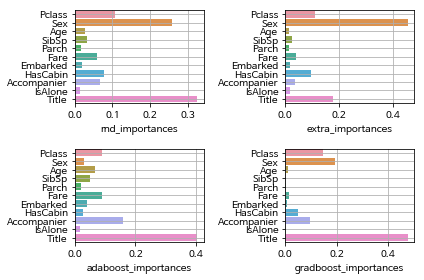

In [60]:
plt.subplot(221)
sns.barplot(importances['rnd_importances'], importances.index.values)
plt.grid()
plt.subplot(222)
sns.barplot(importances['extra_importances'], importances.index.values)
plt.grid()
plt.subplot(223)
sns.barplot(importances['adaboost_importances'], importances.index.values)
plt.grid()
plt.subplot(224)
sns.barplot(importances['gradboost_importances'], importances.index.values)
plt.grid()
plt.tight_layout()

In [61]:
importances['mean'] = importances.mean(axis=1)

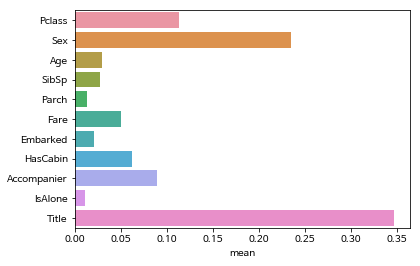

In [62]:
sns.barplot(importances['mean'], importances.index.values)

ensemble 모델들이 Title > Sex > Pclass > ... 순으로 특성 중요도를 나타내고 있다.  
위에서 본 상관계수가 높았던 특성들을 비슷한 순으로 보여주기 때문에 이 특성들이 생존율에 주요 요소라고 다시 한 번 확인할 수 있다.  
Title은 EDA에서 다루지 않았기 때문에 좀 더 살펴본다.

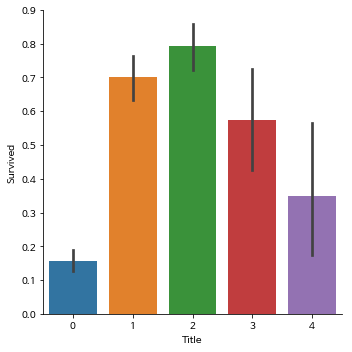

In [63]:
sns.catplot('Title', 'Survived', kind='bar', data=train_transformed)

In [64]:
train_transformed[['Title', 'Survived']].groupby('Title').mean().sort_values('Survived', ascending=False)

,Survived
Title,
2,0.793651
1,0.702703
3,0.575000
4,0.347826
0,0.156673


여성이 생존율이 높은 것을 EDA에서 확인했는데 조건이 더 붙어 기혼 여성(Mrs)의 생존율이 매우 높은 것을 볼 수 있다(79%). 
* Mr : 0
* Miss : 1
* Mrs : 2
* Master : 3
* Rare : 4

## 4.2. Stacking Model
tuning한 모델들 중 가장 성능이 낮은 XGBClassifier를 제외한 모델들로 train set과 test set에 대한 oof 예측을 만들고, XGBClassifier로 oof 예측 데이터셋을 기반으로 최종 예측을 만든다.

### 4.2.1. 1st layer

In [65]:
from sklearn.model_selection import KFold

m_train = X_train_transformed.shape[0]
m_test = X_test_transformed.shape[0]
cv = KFold(5, shuffle=False, random_state=42)

def get_oof(clf, X_train, y_train, X_test):
    oof_train = np.zeros((m_train,))
    oof_test = np.empty((5, m_test))
    oof_test_mean = np.zeros((m_test,))
    
    for i, (idx_train, idx_val) in enumerate(cv.split(X_train)):
        X_train_fold = X_train[idx_train]
        y_train_fold = y_train[idx_train]
        X_val_fold = X_train[idx_val]

        clf.fit(X_train_fold, y_train_fold)
        oof_train[idx_val] = clf.predict(X_val_fold)
        oof_test[i, :] = clf.predict(X_test)
    oof_test_mean[:] = oof_test.mean(axis=0)

    return oof_train.reshape(-1, 1), oof_test_mean.reshape(-1, 1)

In [66]:
X_train = X_train_transformed.values
X_test = X_test_transformed.values
y_train = y_train.ravel()

In [67]:
svc_oof_train, svc_oof_test = get_oof(svc_clf, X_train, y_train, X_test)
rnd_oof_train, rnd_oof_test = get_oof(rnd_clf, X_train, y_train, X_test)
extra_oof_train, extra_oof_test = get_oof(extra_clf, X_train, y_train, X_test)
adaboost_oof_train, adaboost_oof_test = get_oof(adaboost_clf, X_train, y_train, X_test)
gradboost_oof_train, gradboost_oof_test = get_oof(gradboost_clf, X_train, y_train, X_test)

### 4.2.2. 2nd layer

In [68]:
train_pred_from_1st = pd.DataFrame({'RandomForest': rnd_oof_train.ravel(),
                                   'ExtraTrees': extra_oof_train.ravel(),
                                   'AdaBoost': adaboost_oof_train.ravel(),
                                   'GradientBoost': gradboost_oof_train.ravel()})
train_pred_from_1st.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [69]:
X_train_for_2nd = np.concatenate((rnd_oof_train, extra_oof_train, adaboost_oof_train,
                                 gradboost_oof_train, svc_oof_train), axis=1)
X_test_for_2nd = np.concatenate((rnd_oof_test, extra_oof_test, adaboost_oof_test,
                                 gradboost_oof_test, svc_oof_test), axis=1)

In [70]:
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train_for_2nd, y_train)
xgboost_pred = xgboost.predict(X_test_for_2nd)
get_scores([xgboost], X_train_for_2nd, y_train)

,Score
XGBClassifier,83.05


#### submission 

In [72]:
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 
                          'Survived': xgboost_pred})
print(submission.shape)
submission.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [73]:
submission.to_csv('./submission.csv', index=False)